# Lab 5: Word Counting and Embedding Clustering

**Author:** Marcus Klang (Marcus.Klang@cs.lth.se)

## Goals:
 * Learn how to read, transform and process text data with Pyspark
 * Preprocess and create a suitable dataset for clustering
 * Use KMeans from sklearn and cluster 10 000 words to 200 clusters
 * Write a function which displays words nearby
 
## Outline of the lab

 * You will first solve a few exercises on Spark to learn how to write basic commands.
 * You will then apply Spark to extract the 10,000 most frequent words in the English Wikipedia.
 * As this corpus is very large, you will use 1% of it in the lab, the full Wikipedia is available.
 * You will finally cluster these words into 100 groups using their GloVe100 representation.
 * As clustering program, you will use KMeans from sklearn.

In [1]:
# When a cell contains TODO, you shall replace TODO with relevant code.

**Task 0**: Add 1 to 1

In [2]:
#TODO

Answer

In [3]:
1+1

2

## Spark and Pyspark documentation

General documention is available online when you need to look up the parameters of a function:
 
 * [Pyspark RDD](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html)
 * [Pyspark SQL](https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html)
 * [Spark](https://spark.apache.org/docs/2.4.0/)

# Part 0: Dependencies

Import these packages

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [24]:
GLOVE_6B_100D_PATH="../corpus/glove.6B.100d.txt"
ENWIKI_1P_PATH="../corpus/enwiki_1p/"

Copy glove.6B.100d.txt from [Assignment 4](http://cs.lth.se/edan95-applied-machine-learning/lab-programming-assignments/assignment-4/) and set path above

**If you are on your own computer:**

1. Download the 1% Enwiki Paragraph dataset from http://fileadmin.cs.lth.se/cs/Education/EDAN95/Data/enwiki_1p.zip 
2. Extract relative to notebook
3. Make sure the relative directory contains "part-*" files.

## Spark

If you are using the computers in the lab rooms then everything is ready.

**On your own computer:**

These instructions are given in the hope that they are useful and help get you started, support will be minimal to none:

 1. [Download Spark (Mirror choser - get real link from this page)](https://www.apache.org/dyn/closer.lua/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz), link from [https://spark.apache.org/]
 2. Unpack this directory, copy the path to this directory
 3. Make sure you have the [Java 8 **JDK**](https://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) installed and it is the default java. **Spark does not support Java 9+**, if your default java is 9+, then you have to set and export the environment variable JAVA_HOME with the proper location of your java 8 installation before starting your notebook/lab server, which implies that you need to restart the server running this notebook.
 4. Modify SPARK_HOME in the cell below with the copied path and run it.

In [4]:
# This path should point to a location which contains a bin and python directory
#SPARK_HOME="/home/lnxturing/School/EDAN95/spark-2.4.0-bin-hadoop2.7/"
#os.environ["SPARK_HOME"] = SPARK_HOME
#sys.path.append(os.path.join(SPARK_HOME, "python"))
#sys.path.append(os.path.join(SPARK_HOME, "python", "lib", "py4j-0.10.7-src.zip"))

# Part 1: Pyspark RDD

In [3]:
from pyspark import SparkContext   # The main context
from pyspark.sql import SQLContext # The SQL CONTEXT

This utility function will resolve a correct path for Spark

In [4]:
def pyspark_path(filepath):
    return "file:%s" % os.path.abspath(filepath)

We will now create a ```SparkContext``` for testing purposes i.e. run it locally and use all available cores.

```local[*]```, the ```*``` defines the number of cores to use (* = all, 1 = one core, 4 = four cores, etc.).

This will create the Py4j bridge, and start a background JVM which runs the Spark Engine.

In [5]:
sc = SparkContext(master="local[*]", appName="Lab 5")

The ```sc``` variable will provide a link to the driver webpage where status information can be found, along with all settings and more.

In [6]:
sc

<SparkContext master=local[*] appName=Lab 5>

## Part 1.1 Tiny steps with Pyspark

The objective of this section is to get you familiar with different transformations and actions.

All tasks will contain links to the function to use when a new concepts are introduced, when no links exists you are expected to use suitable functions.

Create some dummy data, 100 000 elements from 0 to 99 999, use 8 partitions

In [7]:
dataset = sc.parallelize(list(range(100000)), 8)

**Task 1:** Print the 5 first elements, use the [take](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.take) function

In [8]:
taken = dataset.take(5)
for t in taken:
    print(t)

0
1
2
3
4


**Task 2:** Use [reduce](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.reduce) to sum all values

In [7]:
from operator import add
print(dataset.reduce(add))

NameError: name 'dataset' is not defined

**Task 3:** Sum the values using the [sum](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.sum) function

In [14]:
print(dataset.sum())

4999950000


**Task 4:** Compute the mean using the [mean](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.mean) function

In [15]:
print(dataset.mean())

49999.5


**Task 5:** Add 15 to all elements using [map](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.map), take the first 5 elements

In [16]:
neoDataset = dataset.map(lambda x: x+15, False)
print(neoDataset.take(1))

[15]


**Task 6:** Repeat task 5 but use a function instead of a lambda

In [10]:
def transform(x):
    return x+15

neoDataset = dataset.map(transform)
print(neoDataset.take(1))

[15]


**Task 7:** Filter out odd numbers (divisble by 2 is ```x % 2 == 0```) and compute the mean

In [18]:
neoDataset = dataset.filter(lambda x: x%2 == 0)
print(neoDataset.mean())

49999.0


**Task 8:** Find all odd numbers between 10 000 and 50 000 (inclusive), add 134, find all divisible by 17, [collect](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.collect) and [count](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.count) them.

In [19]:
dataset = sc.parallelize(list(range(10000,50001)),8)
dataset = dataset.map(lambda x: x+134)
dataset = dataset.filter(lambda x: x%17==0)
dataset.collect()
dataset.count()

2353

## Part 1.2 The execution model

Pyspark uses multiple processes for parellization as CPython lacks native threading.

Although possible, shared memory is not used, which means all processes are unique and data which resides in the driver is copied when needed, and state is not transfered

In [8]:
import random

In [21]:
for i in range(3):
    random.seed(1)
    print(dataset.map(lambda x: x+random.randint(0,100)).sum())

71037547
71039990
71039577


Exepected output above is 3 different values, as the random state from the driver is not copied to the executor.

Now we will attempt to make it predictable, by seeding in each process and using a function instead of a lambda.

In addition, the code below will not return all values, instead it will compute a single sum within each partition.

In [9]:
def predictable_map_partition(indx, partition):
    # Whatever code you write here, will run in the executor
    random.seed(indx)
    return [sum(x+random.randint(0,100) for x in partition)]

for i in range(3):
    print(dataset.mapPartitionsWithIndex(predictable_map_partition).sum())

NameError: name 'dataset' is not defined

The output of above is predictable as each partition will be seeded in a predictable manner.

## Part 1.3 Sharing read-only data between executors

It is not uncommon to need some data to be shared between executors.

Common use cases are:
 * Sets/Dictionaries for fast in-memory lookup
 * User-defined objects which contains parameters for the algorithm that should be parallelized
 * General in-memory objects which are used frequently but never modified. These objects might have expensive intialization (such as loading a model, etc.)

Data is shared using a mechanism called *[Broadcasts](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.Broadcast)*, these are serialized objects which are distributed efficiently and shared across muliple calls within a pipeline.

```pickle```is used to serialize objects to transmit over network or locally to executor processes.

In [13]:
lookup = sc.broadcast({"a": "x", "b":"y", "c": "z"})

In [24]:
sc.parallelize(["abc", "def"],1).map(lambda x: "".join([lookup.value.get(ch,ch) for ch in x])).collect()

['xyz', 'def']

In [25]:
setlookup = sc.broadcast(set(["def"]))
sc.parallelize(["abc", "def"],1).filter(lambda x: x in setlookup.value).collect()

['def']

## Part 1.4: Real data

We will be using a 1% sample of all paragraphs in English Wikipedia from October 2018.

The data has been segmented in advance, the following specifics apply:
 
 * Tokens/Words are seperated by space ' '
 * Sentences are seperated by tab characters, '\t'
 * Paragraphs are seperated by newlines, which means that each entry is a full paragraph.

In [13]:
paragraphs = sc.textFile(pyspark_path(ENWIKI_1P_PATH))

**Task 9**: Display the first 5 paragraphs

In [14]:
paragraphs.take(5)

['This article concerns the period 699 BC – 690 BC .',
 'Taipei - based Long Way Enterprise were originally asked to manufacture the ball in their subsidiary YaYork Plastic Products in Shenzhen , Guangdong province , China .\tThe company has been associated with production of Adidas balls since 1997 .',
 "In mid - December 1788 news reached London that Admiral Barrington was frozen up at Cronstadt and would winter there .\tLloyd 's Register for 1789 gives her master 's name as J. Arnott , her owner as G. Thornton , and her trade as London - Copenhagen .",
 "The estimated circulation of Al Riyadh during the early 1990 s was between 100,000 and 120,000 copies .\tIn 2001 the paper had a circulation of 121,000 copies , being the third best selling Saudi newspaper .\tAs for 2002 , its estimated circulation was 91,000 copies .\tThe estimated circulation of the daily in 2003 was 170,000 copies , making it the largest newspaper in the country .\tArab Reform Bulletin gives its 2004 circulation 

**Task 10.** Count the number of paragraphs

In [15]:
paragraphs.count()

355520

**Task 11:** [Sample](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.sample) 1% of these paragraphs, and display the first 5

The use-case of sampling is to speed up testing, getting a downsampled version of the dataset retains the statistical properties.

Please use sampling if execution times are too long. Another tip is to cache the 1% sample in memory for even better performance using [cache()](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.cache), more fingrained caching can be controlled using [persist()](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.persist) and [StorageLevels](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.StorageLevel)

In [16]:
paragraphs.sample(False, 0.01, random.randint(0,10000)).take(5)

['1909–10 , 1911–12 , 1912–13 , 1920–21 , 1921–22 , 1924–25 , 1926–27 , 1927–28 , 1928–29 , 1930–31 , 1934–35 , 1936–37 , 1949–50 , 1950–51 , 1951–52 , 1952–53 , 1954–55 , 1957–58 , 1961–62 , 1967–68 , 1969–70 , 1972–73 , 1974–75 , 1976–77 , 1992–93',
 'British Prime Minister David Cameron stated : " I would like to use this opportunity to make a tribute to King Juan Carlos , who has done so much during his reign to aid the successful Spanish transition to democracy , and has been a great friend of the United Kingdom . " The President of the European Commission , José Manuel Barroso , said that Juan Carlos was a " believer in Europeanism and modernity . . . without whom one could not understand modern Spain " .',
 'The farmland of 3,000 acres ( 12 km ) was purchased by Scripps in 1916 from several different landowners .\tAt its peak , the farm featured angus cattle , cows , swine , sheep , and poultry .\tDuring the Depression years , the farmhands and mansion servants all lived on the 

## Part 2: Preprocessing

The objective of this part is to count words by doing the following parts:
    
 * Convert paragraphs into tokens
 * Normalize tokens into lowercase
 * Count per token
 * Sort and retrieve the top 10000 words in the provided dataset

**Task 12**: Split paragraphs into tokens using [flatMap](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.flatMap), display first 10 tokens

In [17]:
paragraphs = paragraphs.flatMap(lambda x: x.split())

**Task 13:** Lower-case the tokens, display first 10 tokens

In [18]:
paragraphs = paragraphs.map(lambda x: x.lower())

*Remember* you can use a 1% sample during testing

**Task 14:** Count tokens using *map* and [reduceByKey](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.reduceByKey), filter out ```sweden, lund, skåne, learning, spark```, and display counts for these.

In [19]:
paragraphTokens = paragraphs.map(lambda x: (x, 1))
paragraphTokenCount = paragraphTokens.reduceByKey(add)
paragraphTokenFiltered = paragraphTokenCount.filter(lambda x: x[0] in ["skåne", "sweden", "lund", "learning", "spark"])
print(paragraphTokenFiltered.collect())

[('skåne', 13), ('sweden', 1259), ('lund', 70), ('spark', 134), ('learning', 1479)]


**Task 15:** Count the total number of tokens in the corpus

In [20]:
sum = paragraphTokenCount.map(lambda x: x[1]).reduce(add)
print(sum)

24358463


**Task 16:** Take the top 10 000 most frequent tokens using [takeOrdered](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.takeOrdered).

Save the result in a variable called ```top10000```

In [21]:
top10000 = paragraphTokenCount.takeOrdered(10000, key=lambda x: -x[1])

In [22]:
len(top10000)
top10000[1]

(',', 1210718)

## Part 3: Process Glove, and extract the embeddings for the top 10000 words

The objective of this part is:

 * Parse the Glove 6B embedding
 * Filter out only the embeddings matching words that exists in the top 10 000 words.
 * Produce the X which we will cluster

**Task 17:** Load Glove 6B 100d embeddings into a variable ```glove6B```

In [25]:
glove = open(GLOVE_6B_100D_PATH)
embeddings ={}
for line in glove:
    values = line.strip().split()
    word = values[0]
    vector = np.array(values[1:], dtype='float32')
    embeddings[word] = vector
glove.close()
glove6B = embeddings

emb_dict = sc.parallelize(glove6B,8)


**Task 18:** Count the number of embeddings and print the first 5

In [26]:
print(len(emb_dict.collect()))


400000


In [27]:
emb_dict.take(5)

['the', ',', '.', 'of', 'to']

**Task 18:** Parse the embedding by using a function which splits the input into tuples of (word, embedding), display the first 5

In [28]:
emb_dict2 = emb_dict.map(lambda x: (x, embeddings[x]))

In [29]:
emb_dict2.take(5)

[('the',
  array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
         -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
          0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
         -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
          0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
         -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
          0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
          0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
         -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
         -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
         -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
         -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
         -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
         -1.2526

**Task 19:** Filter out the top 10000 embeddings using the provided broadcast ```top10000_set``` which uses the previous ```top10000```variable and use [collectAsMap](https://spark.apache.org/docs/2.4.0/api/python/pyspark.html#pyspark.RDD.collectAsMap) to get a dictionary of the words

In [30]:
top10000_set = sc.broadcast(set([word for word, cnt in top10000]))

In [32]:
top10000_emb = emb_dict2.filter(lambda x: x[0] in top10000_set.value).collectAsMap()

Not all 10 000 words exists in Glove, **9 962** is the expected count

In [33]:
len(top10000_emb)

9963

**Task 20:** Produce the X that we will cluster.

1. Produce a sorted list of tokens
2. Transform list into a list of embeddings and create a numpy array from it

In [40]:
tokens = sorted(top10000_emb.keys())

!
"
$
%
&
'
'd
'll
'm
'n
're
's
've
(
)
*
+
,
-
-0
-1
-10
-12
-15
-16
-17
-18
-19
-1990
-2
-20
-21
-3
-4
-5
-6
-7
-8
-9
.
.1
/
0
0.1
0.2
0.3
0.4
0.5
0.6
0.8
00
05
06
1
1,000
1,200
1,500
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
10
10,000
100
100,000
1000
101
102
103
104
105
106
107
108
109
11
110
111
112
115
116
12
12,000
120
122
125
128
13
130
135
14
140
15
15,000
150
1500
16
160
17
170
1776
1780
1789
1790
1793
1794
1797
18
180
1800
1801
1803
1804
1806
1809
1810
1811
1812
1813
1814
1815
1816
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
19
190
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1

In [50]:
X = np.array([top10000_emb[x] for x in tokens])

-0.23645


## Part 4: Cluster X using KMeans and visualize the results

 * Cluster these embeddings into 100 clusters using [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) from scikit-learn
 * Visualize the results

In [45]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [46]:
kmeans = KMeans(n_clusters=100, n_jobs=-1, random_state=2018)

In [51]:
kmeans.fit(X)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=2018, tol=0.0001, verbose=0)

The code below computes the score which follows this equation:

\begin{equation*}
-\sum_{i=1}^n (\sum_{k=1}^{100} (x_{i,k} - {xc}_{i,k})^2)
\end{equation*}

Where $x$ is the embedding, $xc$ is the assigned cluster center.

*In words:* It is the negative sum of squared differences per dimension (100d).

In [52]:
kmeans.score(X)

-164136.31291007996

**Task 21:** Predict clusters, the output will be indicies. You will find how in the documentation of [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans).

In [53]:
X_clusters = kmeans.predict(X)

In [56]:
print(len(X_clusters))
X_clusters[0:10]

9963


array([57,  0, 35, 24, 78,  0, 57, 57, 57, 79], dtype=int32)

**Task 22:** Create mapping from word to cluster

In [69]:
word_cluster_map = {}
for i in range(len(X_clusters)):
    word_cluster_map[tokens[i]] = X_clusters[i]

**Task 23:** Create mapping from cluster to all words in cluster

In [70]:
cluster_word_map = {}
for i in range(max(X_clusters)+1):
    cluster_word_map[i] = []
for i in range(len(tokens)):
    cluster_word_map[X_clusters[i]].append(tokens[i])
print(cluster_word_map[1])

['africa', 'african', 'algeria', 'angola', 'asia', 'asian', 'australia', 'bangkok', 'bangladesh', 'burma', 'cambodia', 'cameroon', 'chad', 'congo', 'continent', 'ethiopia', 'fiji', 'ghana', 'guinea', 'india', 'indies', 'indo', 'indonesia', 'indonesian', 'ivory', 'jakarta', 'japan', 'kenya', 'korea', 'lanka', 'leone', 'madagascar', 'malaysia', 'malaysian', 'mongolia', 'morocco', 'myanmar', 'namibia', 'nepal', 'nigeria', 'nigerian', 'pakistan', 'papua', 'philippines', 'samoa', 'singapore', 'sri', 'sudan', 'tanzania', 'thai', 'thailand', 'tri', 'tunisia', 'uganda', 'vietnam', 'zealand', 'zimbabwe']


**Task 24**: Create a list of all cluster sizes, i.e. the number of words in each cluster

In [65]:
cluster_size = [len(cluster_word_map[i]) for i in range(max(X_clusters)+1)]
print(cluster_size[0:10])

[153, 57, 75, 147, 98, 115, 75, 95, 88, 123]


Plot the histogram

(array([ 8., 16., 25., 18., 12.,  6.,  8.,  1.,  4.,  2.]),
 array([ 34. ,  52.8,  71.6,  90.4, 109.2, 128. , 146.8, 165.6, 184.4,
        203.2, 222. ]),
 <a list of 10 Patch objects>)

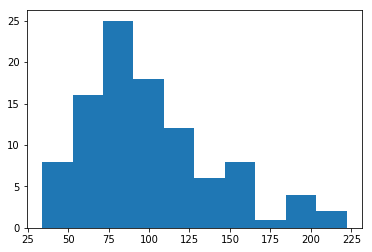

In [66]:
plt.hist(np.array(cluster_size))

**Optionally:** Look at the words in the smallest and largest cluster, do you see any structure?

**Task 25:** Implement the get_nearby function

In [71]:
def get_nearby(word):
    
    return cluster_word_map[word_cluster_map[word]]

In [72]:
get_nearby("sweden")

['albania',
 'armenia',
 'austria',
 'azerbaijan',
 'baltic',
 'belarus',
 'belgium',
 'bosnia',
 'bulgaria',
 'croatia',
 'cyprus',
 'czech',
 'czechoslovakia',
 'denmark',
 'estonia',
 'finland',
 'france',
 'germany',
 'greece',
 'herzegovina',
 'hungary',
 'iceland',
 'italy',
 'kazakhstan',
 'kosovo',
 'latvia',
 'lithuania',
 'luxembourg',
 'macedonia',
 'malta',
 'moldova',
 'montenegro',
 'netherlands',
 'norway',
 'poland',
 'portugal',
 'republic',
 'romania',
 'russia',
 'serbia',
 'slovakia',
 'slovenia',
 'sweden',
 'switzerland',
 'turkey',
 'ukraine',
 'yugoslavia']

In [73]:
words = ["king", "sweden", "obama", "home", "learning"]
clusters = [get_nearby(word) for word in words]
cluster_colors = ["red", "green", "blue", "purple", "teal"] # HTML colors are allowed inside here.

Flatten words and clusters

In [76]:
all_words = [word for cluster in clusters for word in cluster]
all_cluster_color = [
    cluster_color for cluster_color_array in 
    (
        [color] * len(cluster)
        for cluster, color in 
        zip(clusters, cluster_colors)
    )
    for cluster_color
    in cluster_color_array
]
print(len(all_words))

514


**Task 26:** Use ```all_words``` and translate into a numpy array called ```X_words``` of all embeddings

In [77]:
X_words = np.array([top10000_emb[x] for x in all_words])

[**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE) is a dimensionality reduction algorithm useful for projecting high dimensional data into a low dimensional space such as 2D, which we can plot and more easily understand spatially.

In [78]:
tsne = TSNE(n_components=2, random_state=2018)

In [79]:
X_pos = tsne.fit_transform(X_words)

The code below makes a large plot using Matplotlib and attaches labels to all points. It provided for reference and a fallback if the more advanced visualization fails.

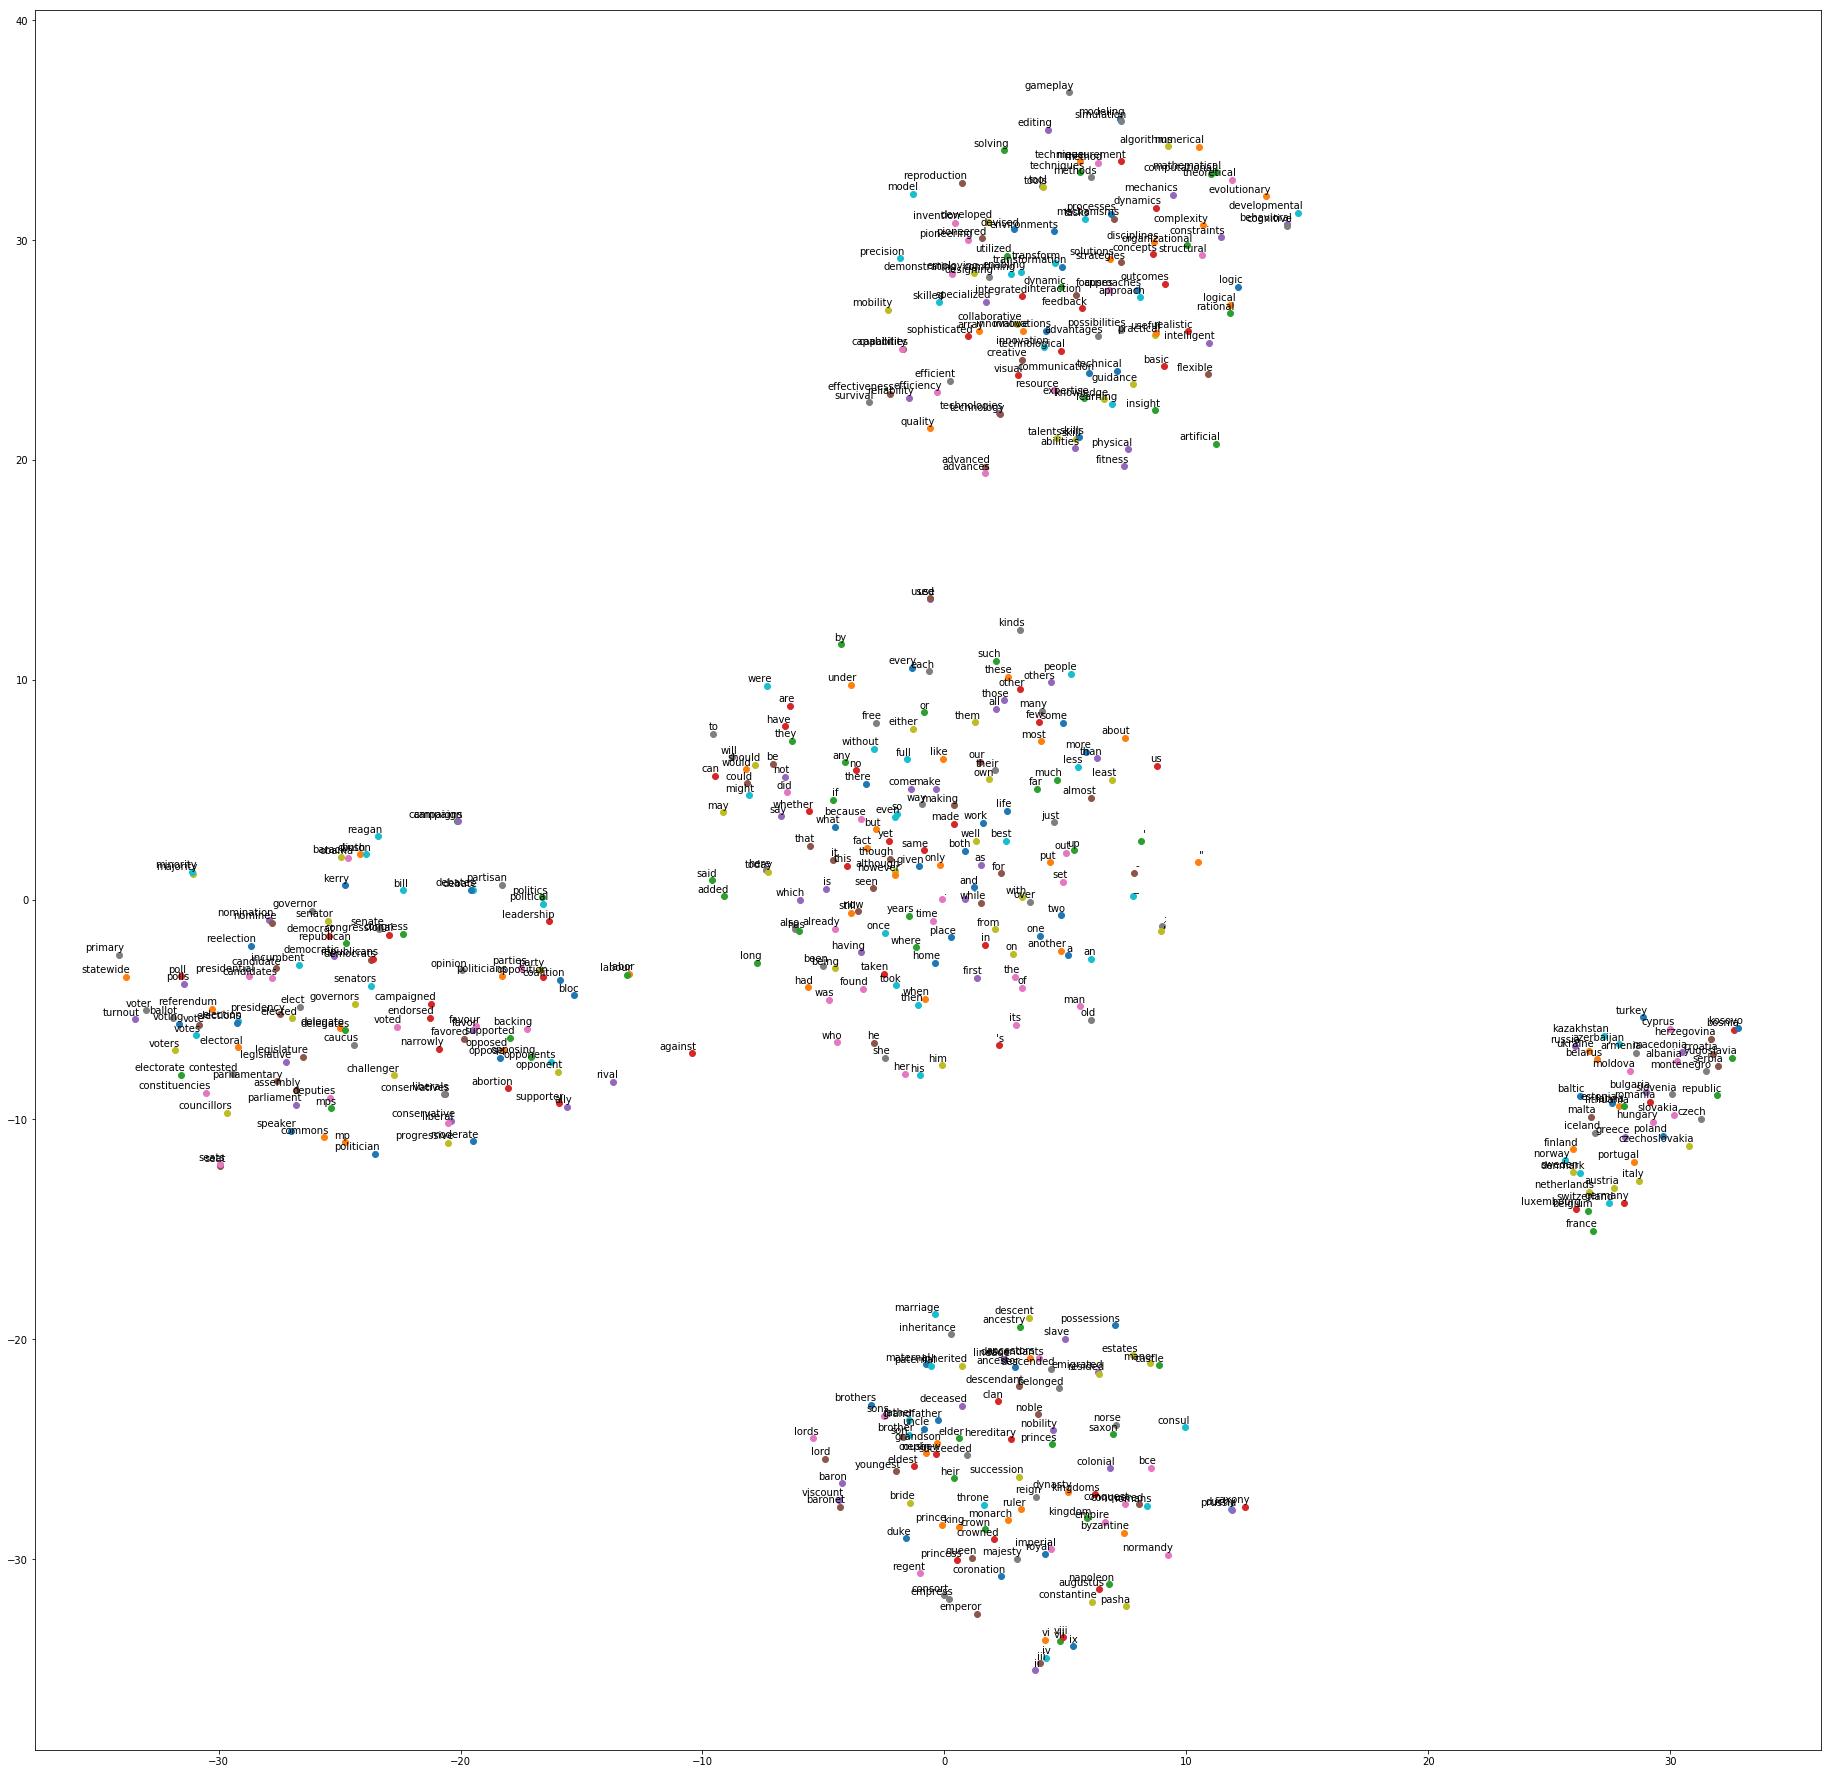

In [80]:
# Visualize using matplotlib and produce an image of the points and words
labels = all_words
x = []
y = []
for x_val,y_val in X_pos:
    x.append(x_val)
    y.append(y_val)

plt.figure(figsize=(32, 32)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

### Interactive Visualization: D3.js
The cells below will produce a HTML file that has the previously plotted image embedded as JSON.

The code below is provided for visualization purposes: to understand it is not a requirement.

The standard output is ```visualize.html```

In [81]:
import json

In [82]:
# Scale to fit box of dimensions below
WIDTH = 768.0
HEIGHT = 768.0
OUTPUT_FILE = "visualize.html"

In [83]:
# Run this cell to set the template
HTML_TEMPLATE = """
<!DOCTYPE html>
<head>
  <style>

      html {
        font-family: "Helvetica Neue", Helvetica, arial, sans-serif;
        font-size: 16px;
      }

      body {
        margin: 0;
        padding: 0;
        width: 100%;
        width: 100%;
        overflow: hidden;
      }

      svg {
        display: block;
        width: 100%;
        height: auto;
      }

      div#container {
        overflow: hidden;
      }
    </style>
    <meta charset="utf-8">
</head>
<body>
  <div class="container">
<svg width="640" height="480"></svg>
<script src="https://d3js.org/d3.v4.min.js"></script>

<!-- Here is our data -->
<script id="raw-data" language="application/json">
__OUTPUT_JSON__
</script>
<script>

// Parse data from tag inside this doucment
var inputdata = JSON.parse(document.getElementById('raw-data').innerHTML);

var svg = d3.select("svg"),
    width = +svg.attr("width"),
    height = +svg.attr("height");

// Create a dummy array with indicies
var indicies = d3.range(inputdata.length);

// Produce points with some zoom magic
var circle = svg.selectAll("circle")
  .data(indicies)
  .enter()
  .append("circle")
    .attr("r", 2.5)
    .attr("fill", function(d) {return inputdata[d]["color"]})
    .attr("transform", transform(d3.zoomIdentity));

// Produce labels attached/placed relative to points
var lbls = svg.selectAll("texts")
                .data(indicies)
                .enter()
                .append("text")
                .text(function(d) {
                  return inputdata[d]["label"];
                })
                .attr("font-size", "15px")
                .attr("fill", function(d) {return inputdata[d]["color"]})
                .attr("transform", transform(d3.zoomIdentity));

// Will recieve index, and produce transform directive for that index
function transform(t) {
  return function(d) {
    return "translate(" + t.apply(inputdata[d]["position"]) + ")";
  };
}

// Zoom transformation function
function zoom() {
  circle.attr("transform", transform(d3.event.transform));
  lbls.attr("transform", transform(d3.event.transform));
}

// Add the zoom handler, that listens to events.
svg.append("rect")
    .attr("fill", "none")
    .attr("pointer-events", "all")
    .attr("width", "100%")
    .attr("height", "100%")
    .call(d3.zoom()
        .scaleExtent([1, 16]) //The minimum and maximum scale factor 
        .on("zoom", zoom));

</script>
</div>
</body>
</html>
"""

In [84]:
# Find extents
x_extents = [min(pos[0] for pos in X_pos), max(pos[0] for pos in X_pos)]
y_extents = [min(pos[1] for pos in X_pos), max(pos[1] for pos in X_pos)]

# Compute translation
translation = [-x_extents[0], -y_extents[0]]

# Compute scaling, flip y to match convention that y is down not up.
scale = [WIDTH/(x_extents[1]-x_extents[0]), -HEIGHT/(y_extents[1]-y_extents[0])]

# Produce JSON dictionary
output = []
labels = all_words
for (x_val, y_val), label, color in zip(X_pos, labels, all_cluster_color):
    output.append({"position": ((float(x_val)+translation[0])*scale[0], (float(y_val)+translation[1])*scale[1]+HEIGHT), "label": label, "color": color})

# Write HTML file with JSON embedded
with open(OUTPUT_FILE, "w") as fout:
    fout.write(HTML_TEMPLATE.replace("__OUTPUT_JSON__", json.dumps(output)))

Open the HTML file in your favorite browser.

How to use:
 * Drag to move the image around
 * Zoom using the mousewheel, default min and max zoom values have been set.

**Note:** *Internet access is required* for the page to work. The page downloads d3.js during start-up from https://d3js.org/d3.v4.min.js